## Introduction

TEAMMATES: Akshat and Annie

The overall goal is to predict whether a payment by a company to a medical doctor or facility
was made as part of a research project or not.

### Imports

In [560]:
# data loading and manipulation
import pandas as pd
import numpy as np
import random
# from dirty_cat import TargetEncoder
from category_encoders import TargetEncoder

# scikit learn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, auc, average_precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# unbalanced sets
from imblearn.under_sampling import RandomUnderSampler

# plotting
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Load data

The positive class corresponds to the payments that were made by a company to a doctor or facility that is part of the **research project**. The negative class on the other hand are the **general payments**. 

In the original data sets, the ratio of the positive class to the negative class is 1/20, making the positive class the minority class. 

Because the data sets are so large, we will subsample from the classes in order to maintain the same ratio. Thus we take 120K data points from Class 0, and 20K data points from Class 1. 

120K from the positive class turns out to be ~20% of the data, and 2M from the negative class is ~20% from the negative class. 

In [2]:
# # Import 20% data randomly
# p = 0.2
# df0 = pd.read_csv('../payments2017/d0.csv', skiprows=lambda i: i>0 and random.random() > p)
# df1 = pd.read_csv('../payments2017/d1.csv', skiprows=lambda i: i>0 and random.random() > p)

# # Write sampled data for future use
# df0.to_csv('../payments2017/gen_payments_sampled.csv')
# df1.to_csv('../payments2017/res_payments_sampled.csv')

In [3]:
# Import from sampled files
df0 = pd.read_csv('../payments2017/gen_payments_sampled.csv')
df1 = pd.read_csv('../payments2017/res_payments_sampled.csv')

In [4]:
df0.shape

(2132686, 76)

In [5]:
df1.shape

(120511, 177)

## Feature Intersection

What features should be excluded because they leak the target information?

There are 75 features present in the negative class, and 176 in the positive class. Our approach to combining the data sets for both the positive and the negative classs it to take an intersection of the features. 

In [6]:
notPrs = list(set(list(df1.columns)).difference(list(df0.columns)))
featureIntersection = list(set(list(df1.columns)).difference(notPrs))
print("There are {} features present in the intersection of the two dataframes.".format(len(featureIntersection) - 1))

df1 = df1[featureIntersection]
df0 = df0[featureIntersection]

There are 64 features present in the intersection of the two dataframes.


Before we concatenate the two data sets, we add an indicator variable to each one specifying which class the data belongs to. We call this feature **target**, which is equal to 1 for the positive class and 0 for the negative class.

In [7]:
df1['Target'] = 1
df0['Target'] = 0

df = pd.concat([df1, df0], axis=0)
df.shape

(2253197, 66)

## NA Columns

We examine the missing values of the data and see that a lot of the features have the majority of their data missing.

In [8]:
NAs = df.isna().mean().sort_values(ascending=False)

In [9]:
NAs

Recipient_Province                                                  0.999945
Recipient_Postal_Code                                               0.999931
Physician_License_State_code5                                       0.999826
Physician_License_State_code4                                       0.999209
Associated_Drug_or_Biological_NDC_5                                 0.997671
Physician_License_State_code3                                       0.995469
Product_Category_or_Therapeutic_Area_5                              0.993623
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5           0.993483
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5            0.993420
Covered_or_Noncovered_Indicator_5                                   0.993296
Teaching_Hospital_CCN                                               0.987752
Teaching_Hospital_Name                                              0.987752
Teaching_Hospital_ID                                                0.987752

## Train-Test Split

In [119]:
features = df.drop(columns='Target')
target = df['Target']
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)
model_scores = dict()

## Random Undersampling and Validation Split

In [121]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_train_rus = pd.DataFrame(X_train_rus, columns = X_train.columns)

X_train, X_val, y_train, y_val = train_test_split(X_train_rus, y_train_rus, random_state=42)

In [125]:
# For some reason, the Total_Amount_of_Payment_USDollars column
# gets converted to type 'object'
# so changing that
X_train.Total_Amount_of_Payment_USDollars = X_train.Total_Amount_of_Payment_USDollars.astype(float)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135904 entries, 38773 to 121958
Data columns (total 65 columns):
Associated_Drug_or_Biological_NDC_4                                 1143 non-null object
Recipient_Primary_Business_Street_Address_Line1                     135834 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5           640 non-null object
Physician_Middle_Name                                               41194 non-null object
Physician_License_State_code4                                       68 non-null object
Physician_Specialty                                                 70418 non-null object
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_3            6199 non-null object
Covered_or_Noncovered_Indicator_3                                   6324 non-null object
Associated_Drug_or_Biological_NDC_2                                 13627 non-null object
Related_Product_Indicator                                           135904 non-nul

## Feature Identification ~ Task 1

We identifying possible irrelevant columns by looking at the features are Names or IDs, such as the hospial ID, record ID, postal codes or physcian names.

In [126]:
columns_to_drop = ['Recipient_Province', 
                    'Recipient_Postal_Code', 
                    'Recipient_Primary_Business_Street_Address_Line2',
                    'Teaching_Hospital_Name', 
                    'Teaching_Hospital_CCN',
                    'Teaching_Hospital_ID',
                    'Physician_Name_Suffix',       
                    'Program_Year', 
                    'Physician_Profile_ID', 
                    'Physician_Last_Name', 
                    'Physician_First_Name',
                    'Record_ID',
                    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
                    'Physician_Profile_ID',
                    'Recipient_Zip_Code',
                    'Date_of_Payment',
                    'Physician_Middle_Name',
                    'Payment_Publication_Date', 
                    'Unnamed: 0' # Index col from one of the DFs
                    ]

As part of out baseline estimate, we will aslo drop columns with any missing value at all. Later on we will not drop all of them and try to impute the missing values.

In [127]:
nan_columns = NAs[NAs > 0] 
nan_columns = np.array(nan_columns.index)
to_drop_baseline = list(set(nan_columns) | set(columns_to_drop))

In [128]:
X_train_Baseline = X_train.drop(columns=to_drop_baseline, axis ='columns')

Checking single variable performances to identify leakage issues

In [129]:
objVars = ['Covered_Recipient_Type', # leaking target info
            'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name', # leaking target info
            'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', # leaking target info
           'Form_of_Payment_or_Transfer_of_Value',
           'Dispute_Status_for_Publication', 
           'Delay_in_Publication_Indicator',
           'Related_Product_Indicator',
           'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
           'Change_Type',
           'Total_Amount_of_Payment_USDollars']

single_var_auc = dict()
single_var_acc = dict()

for var in objVars:
    
    if var != 'Total_Amount_of_Payment_USDollars':
        baseline_pipe = Pipeline([
                                ("dummies", OneHotEncoder(handle_unknown='ignore')),
                                ("logreg", LogisticRegression(solver='lbfgs'))])
    else:
        baseline_pipe = Pipeline([('scalar', StandardScaler()),
                                   ("logreg", LogisticRegression(solver='lbfgs'))])

    # Baseline Training and testing
#     logreg = baseline_pipe.fit(X_train[[var]], y_train)
#     y_score = logreg.predict_proba(X_val[[var]])
    
    # Store in dict
#     single_var_auc[var] = roc_auc_score(y_val, y_score[:, 1])
    
    single_var_acc[var] = np.mean(cross_val_score(baseline_pipe, X_train[[var]], y_train, cv=5))
    
single_var_acc

{'Covered_Recipient_Type': 0.9771750643134993,
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name': 0.7654962361033314,
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name': 0.8547504171677295,
 'Form_of_Payment_or_Transfer_of_Value': 0.8156713240504022,
 'Dispute_Status_for_Publication': 0.5002354610288497,
 'Delay_in_Publication_Indicator': 0.5000956558653123,
 'Related_Product_Indicator': 0.5418678041967537,
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country': 0.5497777905556079,
 'Change_Type': 0.5175417994092365,
 'Total_Amount_of_Payment_USDollars': 0.7378737980278232}

Variables with CV accuracy more than 0.8:

In [131]:
{key: single_var_acc[key] for key in single_var_acc if single_var_acc[key] > 0.8}

{'Covered_Recipient_Type': 0.9771750643134993,
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name': 0.8547504171677295,
 'Form_of_Payment_or_Transfer_of_Value': 0.8156713240504022}

We see that three of the scores stand out: 

- Covered_Recipient_Type,
- Form_of_Payment_or_Transfer_of_Value, and 
- Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name

It is likely that these features leak target information, and so we drop them from the sample. 

Looking at number of unique values in variables:

In [132]:
X_train_Baseline.nunique()

Related_Product_Indicator                                               2
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name         911
Delay_in_Publication_Indicator                                          1
Change_Type                                                             3
Form_of_Payment_or_Transfer_of_Value                                    3
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name             801
Total_Amount_of_Payment_USDollars                                   35713
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country       21
Covered_Recipient_Type                                                  4
Dispute_Status_for_Publication                                          2
dtype: int64

Additionally, we can remove the feature Delay_in_Publication_Indicator as it only has one unique value and would not add important information to the model.

In [133]:
# Augmenting columns to drop
columns_to_drop += ['Covered_Recipient_Type', # leaking target info
                    'Form_of_Payment_or_Transfer_of_Value', # leaking target info
                    'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', # leaking target info
                    'Delay_in_Publication_Indicator' # single unique value
                    ]

In [134]:
to_drop_baseline = list(set(nan_columns) | set(columns_to_drop))

In [135]:
X_train_Baseline = X_train.drop(columns=to_drop_baseline, axis ='columns')

Our new baseline model consists of 7 featues, 6 of which are categorical and 1 that is continuous.

In [136]:
X_train_Baseline.shape

(135904, 6)

In [139]:
X_train_Baseline.head()

,Related_Product_Indicator,Change_Type,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name,Total_Amount_of_Payment_USDollars,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Dispute_Status_for_Publication
38773,Yes,UNCHANGED,Alcon Laboratories Inc,5.65,United States,No
37601,Yes,UNCHANGED,"US WorldMeds, LLC",10.49,United States,No
119118,Yes,UNCHANGED,"AbbVie, Inc.",9240.00,United States,No
70170,Yes,UNCHANGED,"Janssen Pharmaceuticals, Inc",0.95,United States,No
24948,Yes,UNCHANGED,Allergan Inc.,4.84,United States,No


## Baselining ~ Task 2

In [140]:
# Defining continuous and categorical variables
objVars = ['Dispute_Status_for_Publication', 
           'Change_Type',
           'Related_Product_Indicator',
           'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
           'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name']

contVars = ['Total_Amount_of_Payment_USDollars']

In [141]:
# Defining ColumnTransformer
preprocessor = ColumnTransformer(transformers=[("dummies", OneHotEncoder(handle_unknown='ignore'), objVars)],
                                 remainder='passthrough')

# Create pipeplines
baseline_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ("logreg", LogisticRegression(C=1000000, solver='lbfgs', max_iter=1000))
                         ])

In [142]:
# Baseline Training and testing
# logreg = baseline_pipe.fit(pd.DataFrame(X_train_rus, columns = X_train.columns), y_train_rus)
# y_score = logreg.predict_proba(pd.DataFrame(X_train_rus, columns = X_train.columns))
# baseline= roc_auc_score(y_train_rus, y_score[:, 1])

baseline = cross_validate(baseline_pipe, X_train_Baseline, y_train, scoring=['accuracy','roc_auc'], cv=5)
model_scores['baseline_cv_acc'] = np.mean(baseline['test_accuracy'])
model_scores['baseline_cv_roc'] = np.mean(baseline['test_roc_auc'])

In [147]:
model_scores

{'baseline_cv_acc': 0.8667515190390075, 'baseline_cv_roc': 0.944150982940946}

## Feature engineering ~ Task 3

**Handling the NAs:**

Imputing NA with 'Missing' values --> I would still drop variables that have really high number of NAs - because some of them leak target info, but they have so many missing values that they don't actually leak. 

In [148]:
nan_columns = NAs[NAs > 0.5] 
nan_columns = np.array(nan_columns.index)
columns_to_drop = list(set(nan_columns) | set(columns_to_drop))

In [149]:
X_train_engineered = X_train.drop(columns=columns_to_drop)

In [150]:
obj_vars = X_train_engineered.drop(columns=['Total_Amount_of_Payment_USDollars']).columns.values
cont_vars = ['Total_Amount_of_Payment_USDollars']

In [153]:
X_train_engineered.columns

Index(['Recipient_Primary_Business_Street_Address_Line1',
       'Physician_Specialty', 'Related_Product_Indicator',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Physician_License_State_code1',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Change_Type', 'Associated_Drug_or_Biological_NDC_1',
       'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
       'Total_Amount_of_Payment_USDollars',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Recipient_State', 'Product_Category_or_Therapeutic_Area_1',
       'Recipient_City', 'Dispute_Status_for_Publication',
       'Physician_Primary_Type', 'Recipient_Country',
       'Covered_or_Noncovered_Indicator_1'],
      dtype='object')

In [154]:
### Identify high cardinality categorical variables

In [155]:
# # Identify which variables to target encode
# target_based_encoding = []
# for col in obj_vars:
#     print(col, len(X_train_engineered[col].unique()))
    
#     if len(X_train_engineered[col].unique()) > 100:
#         target_based_encoding.append(col)

# len(target_based_encoding)

In [156]:
# # Final categorical variables
# categorical = [cols for cols in obj_vars if cols not in target_based_encoding]
# len(categorical) + len(target_based_encoding)

Checking for target leakage again since we've added features not used before

Impute the missing values of the categorical data with the value "Missing"

In [157]:
single_var_acc = dict()
cat_pipe = Pipeline([
                        ('Impute', SimpleImputer(strategy='constant', fill_value="Missing")),
                        ("dummies", OneHotEncoder(handle_unknown='ignore')),
                        ("logreg", LogisticRegression(C=1000000, solver='lbfgs', max_iter=1000))])

cont_pipe = Pipeline([
                        ('scalar', StandardScaler()),
                        ("logreg", LogisticRegression(C=1000000, solver='lbfgs', max_iter=1000))])

for var in [cols for cols in X_train_engineered.columns if cols not in columns_to_drop]:
    
    if var != 'Total_Amount_of_Payment_USDollars':
        single_var_acc[var] = np.mean(cross_val_score(cat_pipe, X_train_engineered[[var]], y_train, cv=5))
            
    else:
        single_var_acc[var] = np.mean(cross_val_score(cont_pipe, X_train_engineered[[var]], y_train, cv=5))
    
single_var_acc

{'Recipient_Primary_Business_Street_Address_Line1': 0.8825715269498922,
 'Physician_Specialty': 0.9766452789612836,
 'Related_Product_Indicator': 0.5418678041967537,
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State': 0.6236461015882437,
 'Physician_License_State_code1': 0.9771309158274244,
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1': 0.6358900553261095,
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1': 0.8610342787222137,
 'Change_Type': 0.5175417994092365,
 'Associated_Drug_or_Biological_NDC_1': 0.7792117995464899,
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name': 0.7660186625623843,
 'Total_Amount_of_Payment_USDollars': 0.7443710325615659,
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country': 0.5497777905556079,
 'Recipient_State': 0.5676065445663779,
 'Product_Category_or_Therapeutic_Area_1': 0.7931702129612191,
 'Recipient_City': 0.7280727409926517,
 'Dispute_Status_for_Publication': 0.5002354610288497,
 'Physic

Adding leakage variables to list of variables to be removed.

In [158]:
{key: single_var_acc[key] for key in single_var_acc if single_var_acc[key] > 0.8}

{'Recipient_Primary_Business_Street_Address_Line1': 0.8825715269498922,
 'Physician_Specialty': 0.9766452789612836,
 'Physician_License_State_code1': 0.9771309158274244,
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1': 0.8610342787222137,
 'Physician_Primary_Type': 0.9771750643134993}

We see that five of the scores stand out: 
- Recipient_Primary_Business_Street_Address_Line1
- Physician_Specialty
- Physician_License_State_code1
- Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1 and
- Physician_Primary_Type

It is likely that these features leak target information, and so we drop them from the sample. 

In [159]:
columns_to_drop += ['Recipient_Primary_Business_Street_Address_Line1',
                    'Physician_Specialty',
                    'Physician_License_State_code1',
                    'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
                    'Physician_Primary_Type']

In [160]:
X_train_engineered = X_train.drop(columns=columns_to_drop)

In [163]:
X_train_engineered.shape

(135904, 14)

In [164]:
obj_vars = X_train_engineered.drop(columns=['Total_Amount_of_Payment_USDollars']).columns.values
cont_vars = ['Total_Amount_of_Payment_USDollars']

Some categorical columns have too many unique values. We can identify and remove them for the current model and use them for a later model employing Target Encoding. We are thresholding the number of categories as 100 for qualifying for target encoding

In [165]:
# Identify which variables to target encode
target_based_encoding = []
for col in obj_vars:
    print(col, len(X_train_engineered[col].unique()))
    
    if len(X_train_engineered[col].unique()) > 100:
        target_based_encoding.append(col)

len(target_based_encoding)

Related_Product_Indicator 2
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State 43
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1 5
Change_Type 3
Associated_Drug_or_Biological_NDC_1 949
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name 801
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country 21
Recipient_State 55
Product_Category_or_Therapeutic_Area_1 981
Recipient_City 7252
Dispute_Status_for_Publication 2
Recipient_Country 7
Covered_or_Noncovered_Indicator_1 3


4

In [166]:
# Final categorical variables
categorical = [cols for cols in obj_vars if cols not in target_based_encoding]
# Columns used in current model
len(categorical) + len(cont_vars)

10

### Imputed Model 1:
    1. without high cardinality categorical variables 
    2. with Continuous vars Scaled
    3. Imputation = Constant

In [168]:
# Model without high cardinality categorical variables
# Defining ColumnTransformer
preprocessor = ColumnTransformer(transformers=[("scalar", StandardScaler(), cont_vars),
                                              ("dummies", make_pipeline(SimpleImputer(strategy='constant', fill_value="Missing"),
                                                                        OneHotEncoder(handle_unknown='ignore')), categorical)
                                             ])

# Create pipeplines
engineered_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                             ("logreg", LogisticRegression(C=1000000, solver='lbfgs', max_iter=1000))
                            ])



In [170]:
# Baseline Training and testing
imputed_model = cross_validate(engineered_pipe, X_train_engineered, y_train, scoring=['accuracy','roc_auc'], cv=5)
model_scores['imputed_model_cv_score_acc'] = np.mean(imputed_model['test_accuracy'])
model_scores['imputed_model_cv_score_roc'] = np.mean(imputed_model['test_roc_auc'])

In [172]:
model_scores

{'baseline_cv_acc': 0.8667515190390075,
 'baseline_cv_roc': 0.944150982940946,
 'imputed_model_cv_score_acc': 0.8311528813506189,
 'imputed_model_cv_score_roc': 0.9114729386211978}

### Imputed Model 2:
    1. without high cardinality categorical variables 
    2. with Continuous vars Scaled
    3. Imputation = *most_frequent*

In [65]:
# Model without high cardinality categorical variables
# Defining ColumnTransformer
preprocessor = ColumnTransformer(transformers=[("scalar", StandardScaler(), cont_vars),
                                              ("dummies", make_pipeline(SimpleImputer(strategy='most_frequent'),
                                                                        OneHotEncoder(handle_unknown='ignore')), categorical)
                                             ])

# Create pipeplines
engineered_pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                             ("logreg", LogisticRegression(C=1000000, solver='lbfgs', max_iter=1000))
                            ])



In [66]:
# Baseline Training and testing
imputed_model2 = cross_validate(engineered_pipe2, X_train_engineered, y_train, scoring=['accuracy','roc_auc'], cv=5)
model_scores['imputed_model2_cv_score_acc'] = np.mean(imputed_model2['test_accuracy'])
model_scores['imputed_model2_cv_score_roc'] = np.mean(imputed_model2['test_roc_auc'])

In [68]:
model_scores

{'baseline_cv_acc': 0.8741511152010581,
 'baseline_cv_roc': 0.9453738824143099,
 'imputed_model_cv_score_acc': 0.8339383637784976,
 'imputed_model_cv_score_roc': 0.9130853856006222,
 'imputed_model2_cv_score_acc': 0.8343407098791186,
 'imputed_model2_cv_score_roc': 0.912665753434333}

Constant encoding does a better job. This is what we use for any imputation done further (eg. for target encoded variables)

### Imputed + Target Encoded Model 1:
    1. With high cardinality categorical variables 
    2. With Continuous vars Scaled
    3. Imputation = *max_frequency*

In [184]:
X_train_engineered.reset_index().head()

,index,Related_Product_Indicator,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1,Change_Type,Associated_Drug_or_Biological_NDC_1,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name,Total_Amount_of_Payment_USDollars,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Recipient_State,Product_Category_or_Therapeutic_Area_1,Recipient_City,Dispute_Status_for_Publication,Recipient_Country,Covered_or_Noncovered_Indicator_1
0,38773,Yes,TX,Device,UNCHANGED,NaN,Alcon Laboratories Inc,5.65,United States,CA,Ophthalmology,BURBANK,No,United States,Covered
1,37601,Yes,KY,Biological,UNCHANGED,10454-711-10,"US WorldMeds, LLC",10.49,United States,MI,Neurology,SOUTHFIELD,No,United States,Covered
2,119118,Yes,IL,NaN,UNCHANGED,NaN,"AbbVie, Inc.",9240.00,United States,CA,NaN,Simi Valley,No,United States,Non-Covered
3,70170,Yes,NJ,Drug,UNCHANGED,5045-8140-30,"Janssen Pharmaceuticals, Inc",0.95,United States,TX,Cardiovascular & Metabolism,HUNTSVILLE,No,United States,Covered
4,24948,Yes,NJ,Drug,UNCHANGED,61874-115-30,Allergan Inc.,4.84,United States,PA,NEUROSCIENCE,INDIANA,No,United States,Covered


In [187]:
# Target Encoding
# # Takes time (~10mins)
# # but does the job

# Convert NAs of categorical variables to None
for col in target_based_encoding:
    X_train_engineered[col].fillna("Missing", inplace=True)

# Fitting target encoder
target_enc = TargetEncoder(verbose=1, cols=target_based_encoding, return_df=True, handle_unknown='ignore')
targets_encoded = target_enc.fit_transform(X_train_engineered.reset_index(), y_train)

In [195]:
targets_encoded.drop(columns=['index'], inplace=True)
targets_encoded.head()

,Related_Product_Indicator,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1,Change_Type,Associated_Drug_or_Biological_NDC_1,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name,Total_Amount_of_Payment_USDollars,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Recipient_State,Product_Category_or_Therapeutic_Area_1,Recipient_City,Dispute_Status_for_Publication,Recipient_Country,Covered_or_Noncovered_Indicator_1
0,Yes,TX,Device,UNCHANGED,6.429687e-01,0.000000,5.65,United States,CA,0.523640,0.229508,No,United States,Covered
1,Yes,KY,Biological,UNCHANGED,2.069573e-08,0.000000,10.49,United States,MI,0.220053,0.107527,No,United States,Covered
2,Yes,IL,NaN,UNCHANGED,6.429687e-01,0.592631,9240.00,United States,CA,0.822977,0.261852,No,United States,Non-Covered
3,Yes,NJ,Drug,UNCHANGED,9.533898e-03,0.004041,0.95,United States,TX,0.078244,0.225352,No,United States,Covered
4,Yes,NJ,Drug,UNCHANGED,1.444043e-02,0.186290,4.84,United States,PA,0.144172,0.050000,No,United States,Covered


In [198]:
# Defining ColumnTransformer
preprocessor = ColumnTransformer(transformers=[("scalar", StandardScaler(), cont_vars),
                                              ("dummies", make_pipeline(SimpleImputer(strategy='most_frequent'),
                                                                        OneHotEncoder(handle_unknown='ignore')), categorical)
                                             ], remainder='passthrough')

# Create pipeplines
engineered_pipe3 = Pipeline(steps=[('preprocessor', preprocessor),
                             ("logreg", LogisticRegression(C=1000000, solver='lbfgs', max_iter=1000))
                            ])



In [199]:
# Baseline Training and testing
target_enc_model = cross_validate(engineered_pipe3, targets_encoded, y_train, scoring=['accuracy','roc_auc'], cv=5)
model_scores['target_enc_model_cv_score_acc'] = np.mean(target_enc_model['test_accuracy'])
model_scores['target_enc_model_cv_score_roc'] = np.mean(target_enc_model['test_roc_auc'])

In [200]:
model_scores

{'baseline_cv_acc': 0.8667515190390075,
 'baseline_cv_roc': 0.944150982940946,
 'imputed_model_cv_score_acc': 0.8311528813506189,
 'imputed_model_cv_score_roc': 0.9114729386211978,
 'target_enc_model_cv_score_acc': 0.9257049227050917,
 'target_enc_model_cv_score_roc': 0.9767201208979379}

Target encoding siginificantly improves the model performance.

## Any Model ~ Task 4

## Logistic Regression

In [225]:
# Defining ColumnTransformer
preprocessor = ColumnTransformer(transformers=[("scalar", StandardScaler(), cont_vars),
                                              ("dummies", make_pipeline(SimpleImputer(strategy='most_frequent'),
                                                                        OneHotEncoder(handle_unknown='ignore')), categorical)
                                             ], remainder='passthrough')

# Create pipeplines
lr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                             ("logreg", LogisticRegression(solver='lbfgs', max_iter=1000))
                            ])

In [228]:
# grid search params
param_grid_lr = {'logreg__C': np.logspace(-4, 1, 6)}

In [229]:
# Baseline training and testing
lr_model = GridSearchCV(lr_pipe, param_grid = param_grid_lr, cv=5).fit(targets_encoded, y_train)

In [231]:
# print best params
lr_best_params = lr_model.best_params_

# Store best score
lr_model_cv_score = max(lr_model.cv_results_['mean_test_score'])
model_scores['lr_model_cv_score'] = lr_model_cv_score

In [233]:
model_scores, lr_best_params

({'baseline_cv_acc': 0.8667515190390075,
  'baseline_cv_roc': 0.944150982940946,
  'imputed_model_cv_score_acc': 0.8311528813506189,
  'imputed_model_cv_score_roc': 0.9114729386211978,
  'target_enc_model_cv_score_acc': 0.9257049227050917,
  'target_enc_model_cv_score_roc': 0.9767201208979379,
  'svc_model_cv_score': 0.915867082646574,
  'lr_model_cv_score': 0.9255209559689193},
 {'logreg__C': 10.0})

In [228]:
# grid search params
param_grid_lr = {'logreg__C': np.logspace(-4, 1, 6)}

In [229]:
# Baseline training and testing
lr_model = GridSearchCV(lr_pipe, param_grid = param_grid_lr, cv=5).fit(targets_encoded, y_train)

In [231]:
# print best params
lr_best_params = lr_model.best_params_

# Store best score
lr_model_cv_score = max(lr_model.cv_results_['mean_test_score'])
model_scores['lr_model_cv_score'] = lr_model_cv_score

## Linear SVC

In [218]:
# Defining ColumnTransformer
preprocessor = ColumnTransformer(transformers=[("scalar", StandardScaler(), cont_vars),
                                              ("dummies", make_pipeline(SimpleImputer(strategy='most_frequent'),
                                                                        OneHotEncoder(handle_unknown='ignore')), categorical)
                                             ], remainder='passthrough')

# Create pipeplines
svc_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("SVC", LinearSVC()) 
                          ])

In [219]:
# grid search params
param_grid_svc = {'SVC__C': np.logspace(-4, 1, 6)}

In [220]:
# Baseline training and testing
svc_model = GridSearchCV(svc_pipe, param_grid = param_grid_svc, cv=5).fit(targets_encoded, y_train)

In [222]:
# print best params
svc_best_params = svc_model.best_params_

# Store best score
svc_model_cv_score = max(svc_model.cv_results_['mean_test_score'])
model_scores['svc_model_cv_score'] = svc_model_cv_score

In [223]:
model_scores

{'baseline_cv_acc': 0.8667515190390075,
 'baseline_cv_roc': 0.944150982940946,
 'imputed_model_cv_score_acc': 0.8311528813506189,
 'imputed_model_cv_score_roc': 0.9114729386211978,
 'target_enc_model_cv_score_acc': 0.9257049227050917,
 'target_enc_model_cv_score_roc': 0.9767201208979379,
 'svc_model_cv_score': 0.915867082646574}

## Random Forest Classifier

Baseline Random Forest

In [234]:
# Defining ColumnTransformer
preprocessor = ColumnTransformer(transformers=[("scalar", StandardScaler(), cont_vars),
                                              ("dummies", make_pipeline(SimpleImputer(strategy='most_frequent'),
                                                                        OneHotEncoder(handle_unknown='ignore')), categorical)
                                             ], remainder='passthrough')

# Create pipeplines
rf_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("rf", RandomForestClassifier()) 
                          ])

In [235]:
param_grid_rf = {'rf__max_depth': [10, 50, 70, 100]}
#                 'rf__min_samples_split ': [10, 50, 100]}

In [236]:
# training and testing
rf_model = GridSearchCV(rf_pipe, param_grid = param_grid_rf, cv=5).fit(targets_encoded, y_train)

In [237]:
# print best params
rf_best_params = rf_model.best_params_

# Store best score
rf_model_cv_score = max(rf_model.cv_results_['mean_test_score'])
model_scores['rf_model_cv_score'] = rf_model_cv_score

In [239]:
model_scores, rf_best_params

({'baseline_cv_acc': 0.8667515190390075,
  'baseline_cv_roc': 0.944150982940946,
  'imputed_model_cv_score_acc': 0.8311528813506189,
  'imputed_model_cv_score_roc': 0.9114729386211978,
  'target_enc_model_cv_score_acc': 0.9257049227050917,
  'target_enc_model_cv_score_roc': 0.9767201208979379,
  'svc_model_cv_score': 0.915867082646574,
  'lr_model_cv_score': 0.9255209559689193,
  'rf_model_cv_score': 0.9723849187661879},
 {'rf__max_depth': 50})

## XGB Classifier

In [249]:
# Defining ColumnTransformer
preprocessor = ColumnTransformer(transformers=[("scalar", StandardScaler(), cont_vars),
                                              ("dummies", make_pipeline(SimpleImputer(strategy='most_frequent'),
                                                                        OneHotEncoder(handle_unknown='ignore')), categorical)
                                             ], remainder='passthrough')

# Create pipeplines
xgb_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("xgb", GradientBoostingClassifier(subsample=0.8)) 
                          ])

In [250]:
param_grid_xgb = {'xgb__n_estimators': [10, 25, 50]}

In [251]:
# training and testing
xgb_model = GridSearchCV(xgb_pipe, param_grid = param_grid_xgb, cv=5).fit(targets_encoded, y_train)

In [252]:
# print best params
xgb_best_params = xgb_model.best_params_

# Store best score
xgb_model_cv_score = max(xgb_model.cv_results_['mean_test_score'])
model_scores['xgb_model_cv_score'] = xgb_model_cv_score

In [253]:
model_scores, xgb_best_params

({'baseline_cv_acc': 0.8667515190390075,
  'baseline_cv_roc': 0.944150982940946,
  'imputed_model_cv_score_acc': 0.8311528813506189,
  'imputed_model_cv_score_roc': 0.9114729386211978,
  'target_enc_model_cv_score_acc': 0.9257049227050917,
  'target_enc_model_cv_score_roc': 0.9767201208979379,
  'svc_model_cv_score': 0.915867082646574,
  'lr_model_cv_score': 0.9255209559689193,
  'rf_model_cv_score': 0.9723849187661879,
  'xgb_model_cv_score': 0.9569181186720037},
 {'xgb__n_estimators': 50})

## Validation set statistics

### Preprocessing

In [285]:
# Remove columns to be removed
X_val_dropped = X_val.drop(columns=columns_to_drop)

# Target based encoding
# # Manually fill in NA values
for col in target_based_encoding:
    X_val_dropped[col].fillna("Missing", inplace=True)

# Transforming using fitted target encoder
# target_enc = TargetEncoder(verbose=1, cols=target_based_encoding, return_df=True, handle_unknown='ignore')
targets_encoded_val = target_enc.transform(X_val_dropped.reset_index())
targets_encoded_val.drop(columns='index', inplace=True)

In [259]:
# For some reason, the Total_Amount_of_Payment_USDollars column
# gets converted to type 'object'
# so changing that
targets_encoded_val.Total_Amount_of_Payment_USDollars = targets_encoded_val.Total_Amount_of_Payment_USDollars.astype(float)
targets_encoded_val.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45302 entries, 0 to 45301
Data columns (total 15 columns):
index                                                               45302 non-null int64
Related_Product_Indicator                                           45302 non-null object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State      42686 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1           37064 non-null object
Change_Type                                                         45302 non-null object
Associated_Drug_or_Biological_NDC_1                                 45265 non-null float64
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name           45238 non-null float64
Total_Amount_of_Payment_USDollars                                   45302 non-null float64
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country    45302 non-null object
Recipient_State                                                     45262 non-n

### Fitting models with best paramaters for each of the above models

In [261]:
val_scores = dict()

In [408]:
validation_set = targets_encoded_val

In [409]:
# Remove nans from targets_encoded
for col in target_based_encoding:
    validation_set[col].fillna(0, inplace=True)

In [412]:
# Logistic Regression
lr_val_predict = lr_model.predict(validation_set)
val_scores['logreg_val'] = accuracy_score(y_val, lr_val_predict)

In [413]:
val_scores

{'logreg_val': 0.9205774579488765}

In [414]:
# Linear SVC
svc_val_predict = svc_model.predict(validation_set)
val_scores['svc_val'] = accuracy_score(y_val, svc_val_predict)

In [415]:
# Random Forest
rf_val_predict = rf_model.predict(validation_set)
val_scores['rf_val'] = accuracy_score(y_val, rf_val_predict)

In [416]:
# Gradient Boosting
xgb_val_predict = xgb_model.predict(validation_set)
val_scores['gb_val'] = accuracy_score(y_val, xgb_val_predict)

In [418]:
val_scores

{'logreg_val': 0.9205774579488765,
 'svc_val': 0.9110414551233941,
 'rf_val': 0.9719659176195311,
 'gb_val': 0.9532250231777847}

## RF is the best model !

## Feature Importance ~ Task 5 

In [482]:
# Storing feature names for future reference
fit1 = rf_pipe.fit(targets_encoded, y_train) 


In [503]:
cat_features = fit1.steps[0][-1].named_transformers_['dummies'].steps[-1][-1].get_feature_names()
cat_features = cat_features.tolist()
feature_names = cont_vars + cat_features + target_based_encoding
len(feature_names)

141

In [435]:
feature_importances = rf_model.best_estimator_.steps[-1][1].feature_importances_

In [519]:
indices

array([ 55,  71,  45, 134, 135, 140, 136, 139, 137, 138], dtype=int64)

In [526]:
top_feature_names = [feature_names[i] for i in indices]

Text(0.5, 0, 'Relative Importance')

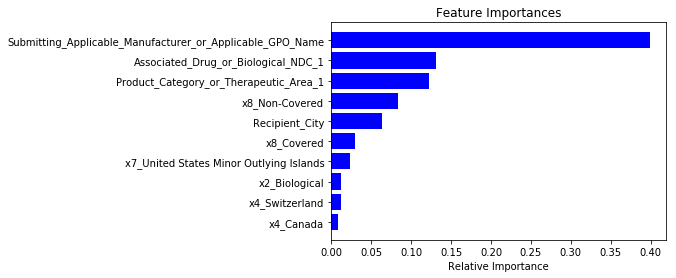

In [527]:
indices = np.argsort(feature_importances)[-10:]

plt.figure(1)
plt.title('Feature Importances')
plt.barh(top_feature_names, feature_importances[indices], color='b', align='center')
# plt.yticks(range(10), feature_names[indices])
plt.xlabel('Relative Importance')

## Keeping only top 10 variables by importance 

In [562]:
categorical

['Related_Product_Indicator',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Change_Type',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
 'Recipient_State',
 'Dispute_Status_for_Publication',
 'Recipient_Country',
 'Covered_or_Noncovered_Indicator_1']

In [536]:
top_feature_names

['x4_Canada',
 'x4_Switzerland',
 'x2_Biological',
 'x7_United States Minor Outlying Islands',
 'x8_Covered',
 'Recipient_City',
 'x8_Non-Covered',
 'Product_Category_or_Therapeutic_Area_1',
 'Associated_Drug_or_Biological_NDC_1',
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name']

In [538]:
vars_to_keep = ['Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
                'Associated_Drug_or_Biological_NDC_1',
               'Product_Category_or_Therapeutic_Area_1',
               'Recipient_City',
               'Covered_or_Noncovered_Indicator_1']

In [539]:
reduced = targets_encoded[vars_to_keep]
reduced.head()

,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name,Associated_Drug_or_Biological_NDC_1,Product_Category_or_Therapeutic_Area_1,Recipient_City,Covered_or_Noncovered_Indicator_1
0,0.000000,6.429687e-01,0.523640,0.229508,Covered
1,0.000000,2.069573e-08,0.220053,0.107527,Covered
2,0.592631,6.429687e-01,0.822977,0.261852,Non-Covered
3,0.004041,9.533898e-03,0.078244,0.225352,Covered
4,0.186290,1.444043e-02,0.144172,0.050000,Covered


In [567]:
# Defining ColumnTransformer
preprocessor = ColumnTransformer(transformers=[("dummies", make_pipeline(SimpleImputer(strategy='most_frequent'),
                                                                        OneHotEncoder(handle_unknown='ignore')), ['Covered_or_Noncovered_Indicator_1'])
                                             ], remainder='passthrough')

# Create pipeplines
rf_pipe_reduced = Pipeline(steps=[("preprocessor", preprocessor),
                           ("rf", RandomForestClassifier(max_depth=50)) 
                          ])

In [568]:
# training and testing
rf_model_reduced = rf_pipe_reduced.fit(reduced, y_train)

In [570]:
reduced_val = targets_encoded_val[vars_to_keep]

In [571]:
# Store best score
reduced_predictions = rf_model_reduced.predict(reduced_val)
reduced_accuracy = accuracy_score(reduced_predictions, y_val)
reduced_accuracy

0.9280384971965918

# Code for drawing ROC curve

In [ ]:
y_score = logreg.fit(pd.DataFrame(X_train_rus, columns = X_train.columns), 
                     pd.DataFrame(y_train_rus)).predict_proba(X_test)

In [ ]:
preds = logreg.predict(X_test)
tn, fp, fn, tp  = confusion_matrix(y_test, preds).ravel()
print([tn, fp])
print([fn, tp])

In [ ]:
roc_auc_score(y_test, y_score[:, 1])

In [ ]:
plot_roc(y_test, list(y_score[:, 1]))

In [ ]:
average_precision_score(y_test, y_score)

In [ ]:
def plot_roc(y_test, y_score):
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    roc_auc = auc(fpr, tpr)
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
y_prob = logreg.predict_proba(X_test)